## Домашнее задание

#### Задача

##### Понять почему 30-дневный прогноз цены на криптовалюту резко падает или вовсе не совпадает с реальными данными, визуализировать процессы обучения и сделать выводы.

#### Подсказки

1. Модели не учитывают важные факторы или данных для обучения недостаточно. Использовались ли только исторические цены закрытия, или были добавлены другие признаки? Данные включают только столбец `Close`, что ограничивает модель в изучении других факторов, влияющих на цену.
2. Проблема связана с нормализацией данных. Использовался `MinMaxScaler` в диапазоне $(0,1)$. Если последние значения в последовательности близки к **1**, то прогнозируемые значения могут выходить за пределы этого диапазона, что приводит к некорректным предсказаниям после обратного преобразования. Стоит попробовать другие методы нормализации или масштабирования.
3. Проверить, как реализовано прогнозирование на несколько шагов вперед. Функция `forecast` предсказывает каждый следующий день, добавляя его в последовательность. Однако накопление ошибок может привести к ошибке предсказаний. Нужно обратить внимание на то, как модель обрабатывает многократные предсказания: возможно, она начинает предсказывать среднее значение или шум после нескольких шагов.
4. Проверить качество обучения модели. Если модель недообучена или переобучена, то прогнозы будут неточными. Нужно посмотреть на график потерь во время обучения. Попробовать увеличить количество эпох, изменить скорость обучения или заменить функцию активации.
5. Проверить разделение данных на обучающую и тестовую выборки. Если тестовая выборка содержит необычные шаблоны или выбросы, модель будет плохо на них реагировать. Убедиться, что данные разделены правильно и временные зависимости учтены корректно.
6. Неадекватная архитектура модели. Проверить увеличение количества нейронов или слоев.
7. Обратить внимание на длину последовательности (`seq_length`). Если окно слишком большое или маленькое, модель будет не улавливать нужные зависимости.
8. Может проблема в самом характере данных? Цены волатильны и подвержены влиянию внешних факторов, которые не учтены в модели.
9. Может ошибки в коде?

### Решение

In [ ]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler

## Процесс обучения RNN

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Epoch 0, Loss: 0.040334
Epoch 10, Loss: 0.023410
Epoch 20, Loss: 0.023138
Epoch 30, Loss: 0.022605
Epoch 40, Loss: 0.021535
Epoch 50, Loss: 0.019426
Epoch 60, Loss: 0.015518
Epoch 70, Loss: 0.009324
Epoch 80, Loss: 0.002897
Epoch 90, Loss: 0.000404


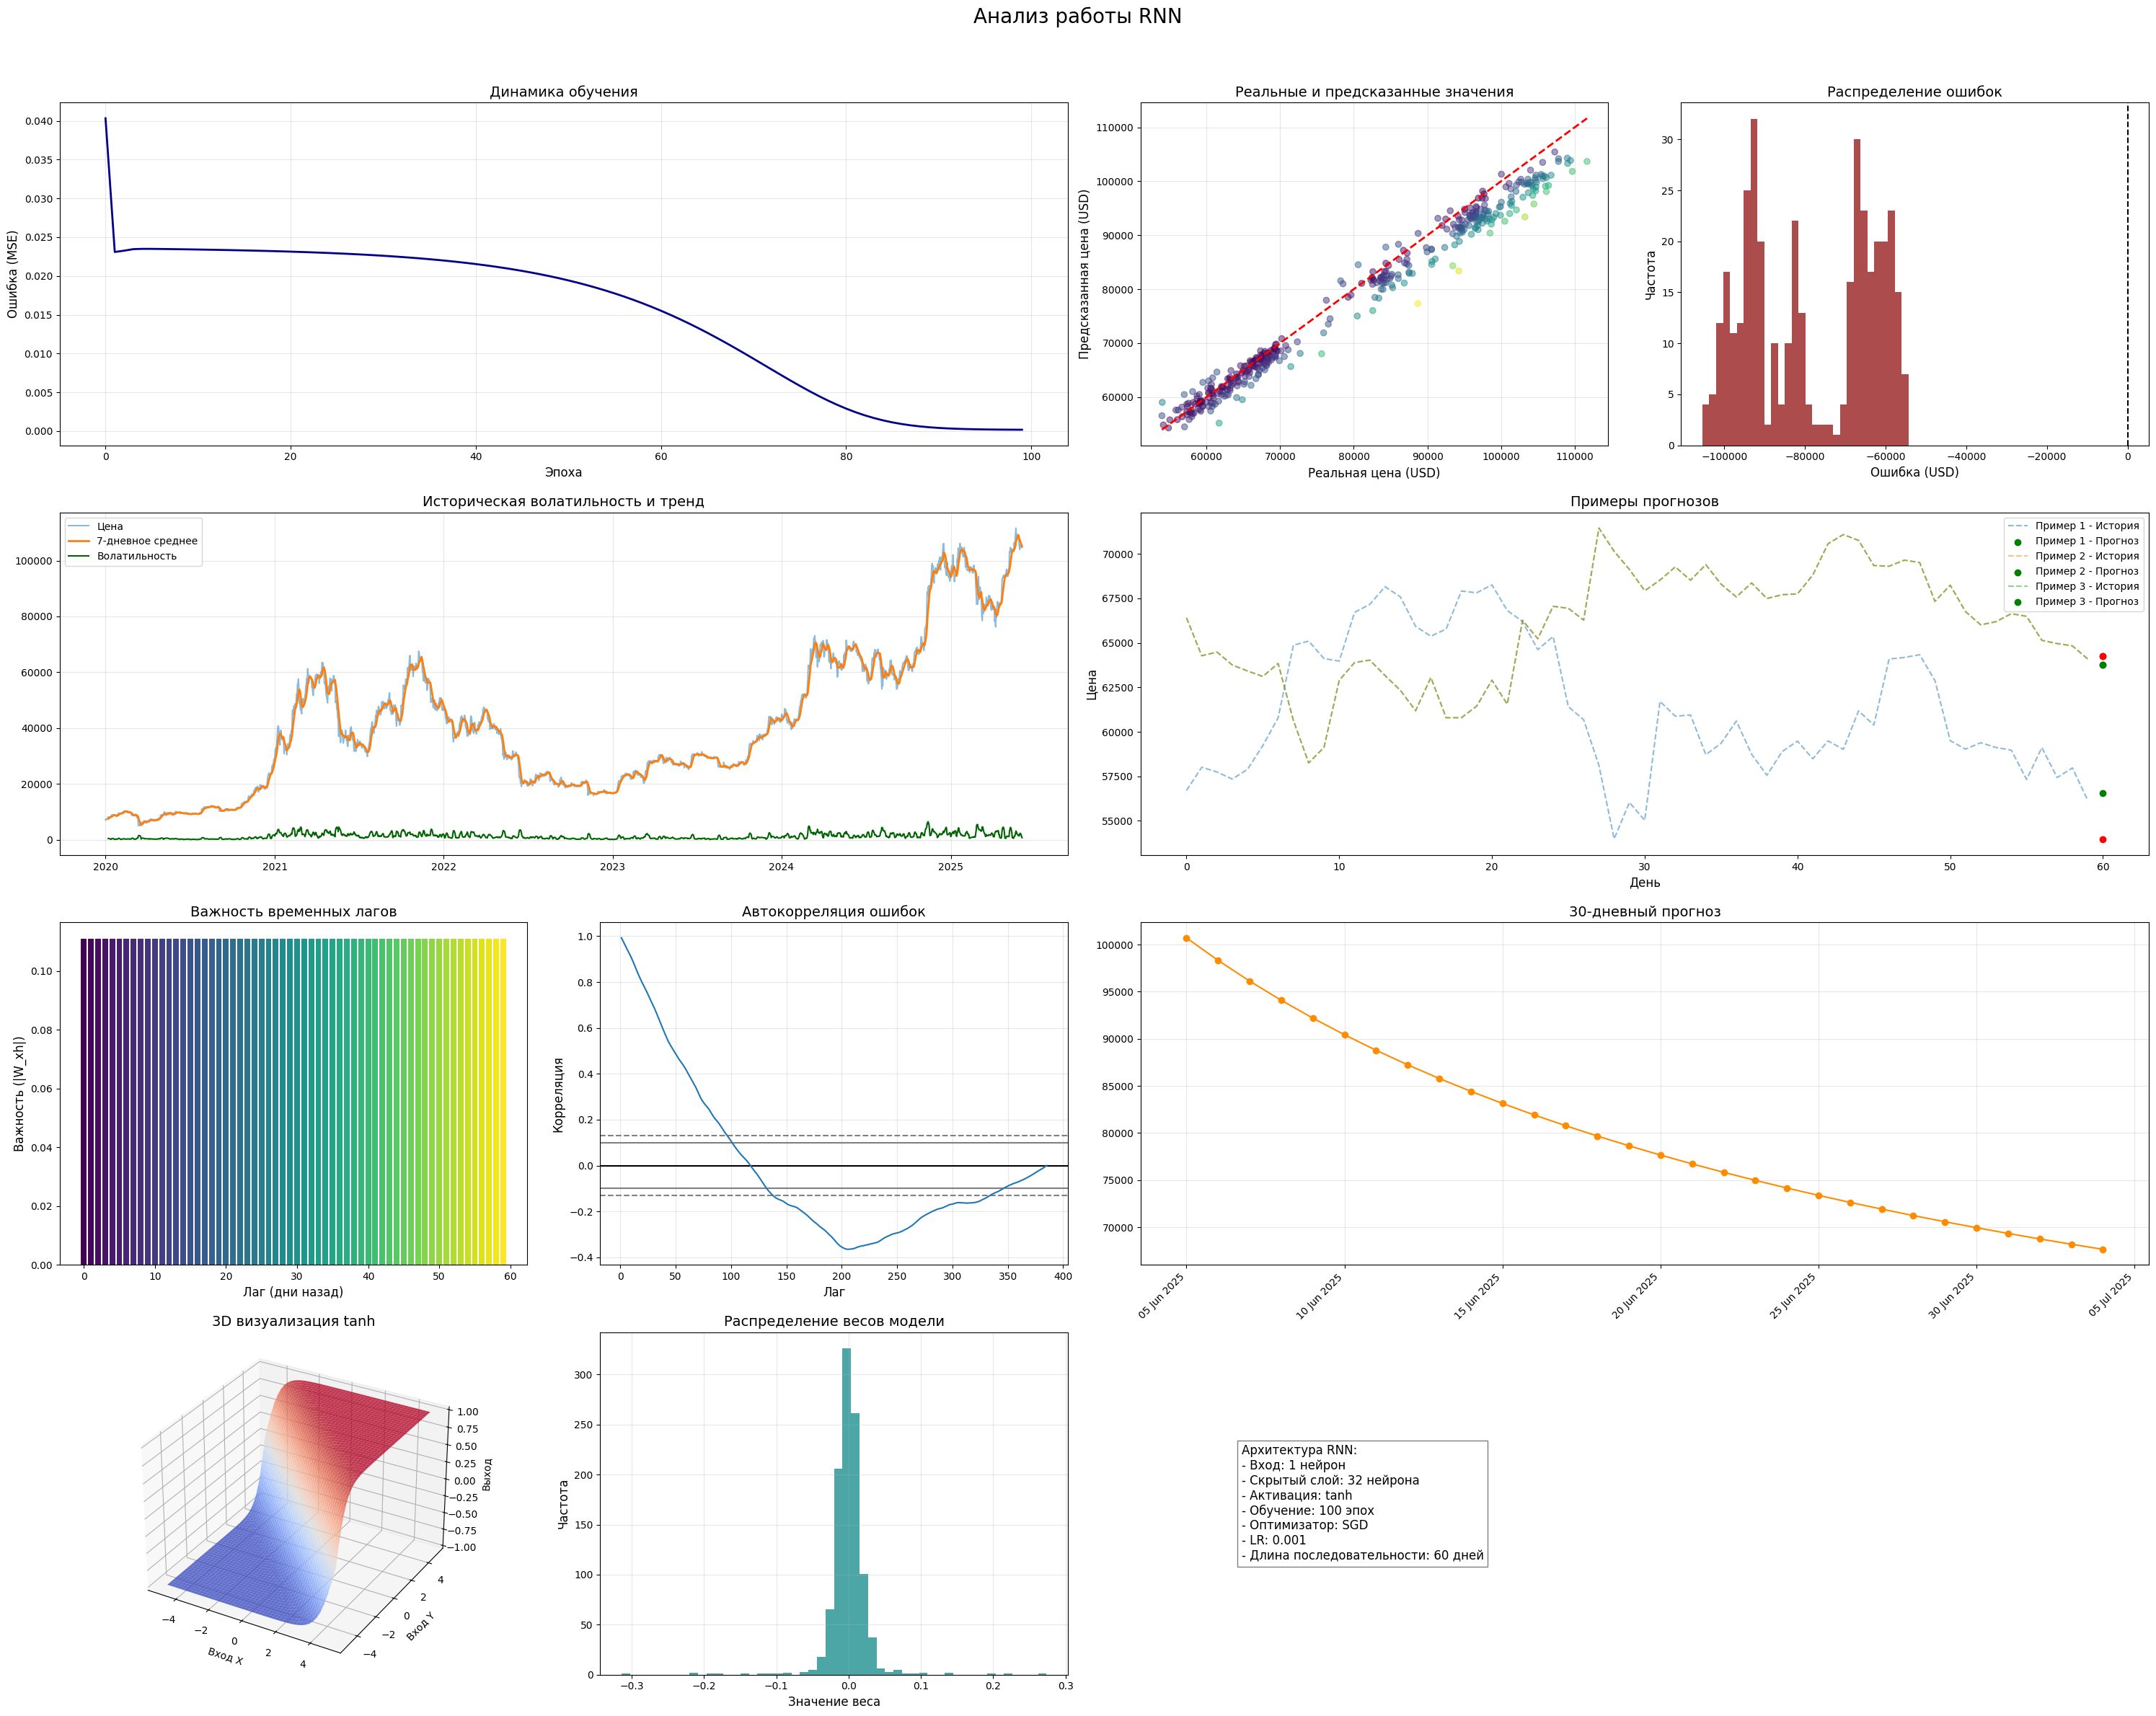

In [2]:
# Загрузка данных
ticker = "BTC-USD"
data = yf.download(ticker, start = "2020-01-01", end = pd.Timestamp.now().strftime('%Y-%m-%d'))
data = data[['Close']]

# Нормализация данных
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data)

# Создание последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Разделение данных
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Реализация RNN
class SimpleRNN:
    def __init__(self, input_size, hidden_size):
        self.W_xh = np.random.randn(hidden_size, input_size) * 0.01
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.b_h = np.zeros((hidden_size, 1))
        self.W_hy = np.random.randn(1, hidden_size) * 0.01
        self.b_y = np.zeros((1, 1))
    
    def forward(self, inputs):
        h_prev = np.zeros((self.W_hh.shape[0], 1))
        self.hs = [h_prev]
        self.outputs = []
        for x in inputs:
            x = x.reshape(-1, 1)
            h = np.tanh(self.W_xh @ x + self.W_hh @ h_prev + self.b_h)
            y = self.W_hy @ h + self.b_y
            self.hs.append(h)
            self.outputs.append(y)
            h_prev = h
        return self.outputs[-1]
    
    def backward(self, inputs, target, lr = 0.001):
        dW_xh, dW_hh, db_h = 0, 0, 0
        dW_hy, db_y = 0, 0
        dh_next = np.zeros_like(self.hs[0])
        
        dy = (self.outputs[-1] - target.reshape(-1, 1))
        dW_hy += dy @ self.hs[-1].T
        db_y += dy
        
        dh = self.W_hy.T @ dy + dh_next
        for t in reversed(range(len(inputs))):
            x = inputs[t].reshape(-1, 1)
            h_current = self.hs[t+1]
            h_prev = self.hs[t]
            
            dtanh = (1 - h_current ** 2) * dh
            dW_xh += dtanh @ x.T
            dW_hh += dtanh @ h_prev.T
            db_h += dtanh
            
            dh = self.W_hh.T @ dtanh
        
        clip_value = 5.0
        for grad in [dW_xh, dW_hh, dW_hy]:
            np.clip(grad, -clip_value, clip_value, out = grad)
        
        self.W_xh -= lr * dW_xh
        self.W_hh -= lr * dW_hh
        self.b_h -= lr * db_h
        self.W_hy -= lr * dW_hy
        self.b_y -= lr * db_y

# Параметры модели
input_size = 1
hidden_size = 32
lr = 0.001
epochs = 100

rnn = SimpleRNN(input_size, hidden_size)

# Обучение модели
loss_history = []
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(len(X_train)):
        inputs = X_train[i].reshape(-1, 1)
        target = y_train[i]
        
        output = rnn.forward(inputs)
        loss = (output - target.reshape(-1, 1)) ** 2
        epoch_loss += loss.item()
        
        rnn.backward(inputs, target, lr)
    
    avg_loss = epoch_loss / len(X_train)
    loss_history.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

# Функция прогнозирования
def forecast(model, last_sequence, days = 30):
    predictions = []
    current_seq = last_sequence.copy()
    for _ in range(days):
        next_pred = model.forward(current_seq)
        predictions.append(next_pred.item())
        current_seq = np.append(current_seq[1:], next_pred)
    return predictions

# Генерация предсказаний на тестовых данных
test_predictions = []
for i in range(len(X_test)):
    inputs = X_test[i].reshape(-1, 1)
    output = rnn.forward(inputs)
    test_predictions.append(output.item())

# Преобразование предсказаний обратно в исходный масштаб цен
test_predictions_inv = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Прогноз на N дней
last_sequence = scaled_data[-seq_length:].reshape(-1, 1)
scaled_forecast = forecast(rnn, last_sequence, days = 30)
forecast_prices = scaler.inverse_transform(np.array(scaled_forecast).reshape(-1, 1))

# Создание единой фигуры с subplots
plt.figure(figsize = (30, 25))
plt.suptitle("Анализ работы RNN", y = 0.95, fontsize = 20)

# 1. График обучения
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan = 2)
ax1.plot(loss_history, color = "darkblue", linewidth = 2)
ax1.set_title("Динамика обучения", fontsize = 14)
ax1.set_xlabel("Эпоха", fontsize = 12)
ax1.set_ylabel("Ошибка (MSE)", fontsize = 12)
ax1.grid(True, alpha=0.3)

# 2. Сравнение реальных и предсказанных значений
ax2 = plt.subplot2grid((4, 4), (0, 2))
ax2.scatter(y_test_inv, test_predictions_inv, alpha = 0.5, c = np.abs(y_test_inv - test_predictions_inv), cmap = "viridis")

min_val = min(y_test_inv.min(), test_predictions_inv.min())
max_val = max(y_test_inv.max(), test_predictions_inv.max())
ax2.plot([min_val, max_val], [min_val, max_val], "--r", linewidth = 2)

ax2.set_title("Реальные и предсказанные значения", fontsize = 14)
ax2.set_xlabel("Реальная цена (USD)", fontsize = 12)
ax2.set_ylabel("Предсказанная цена (USD)", fontsize = 12)
ax2.grid(alpha = 0.3)

# 3. Распределение ошибок
ax3 = plt.subplot2grid((4, 4), (0, 3))
errors = y_test - test_predictions_inv
ax3.hist(errors, bins = 30, color = "darkred", alpha = 0.7)
ax3.set_title("Распределение ошибок", fontsize = 14)
ax3.set_xlabel("Ошибка (USD)", fontsize = 12)
ax3.set_ylabel("Частота", fontsize = 12)
ax3.axvline(x = 0, color = "black", linestyle = "--")

# 4. Скользящее среднее и волатильность
ax4 = plt.subplot2grid((4, 4), (1, 0), colspan = 2)
window_size = 7
data["MA_7"] = data["Close"].rolling(window = window_size).mean()
data["Volatility"] = data["Close"].rolling(window = window_size).std()
ax4.plot(data["Close"], label = "Цена", alpha = 0.5)
ax4.plot(data["MA_7"], label = "7-дневное среднее", linewidth = 2)
ax4.plot(data["Volatility"], label = "Волатильность", color = "darkgreen")
ax4.set_title("Историческая волатильность и тренд", fontsize = 14)
ax4.legend()
ax4.grid(alpha = 0.3)

# 5. Примеры прогнозов
ax5 = plt.subplot2grid((4, 4), (1, 2), colspan = 2)
for i in range(3):
    idx = np.random.randint(len(X_test))
    seq = X_test[idx]
    pred = rnn.forward(seq.reshape(-1, 1))
    real = scaler.inverse_transform(y_test[idx].reshape(-1, 1))
    ax5.plot(scaler.inverse_transform(seq), alpha = 0.5, linestyle = "--", label = f"Пример {i+1} - История")
    ax5.scatter(len(seq), real, color = "red", zorder = 5)
    ax5.scatter(len(seq), scaler.inverse_transform(pred), color = "green", zorder = 5, label = f"Пример {i+1} - Прогноз")
ax5.set_title("Примеры прогнозов", fontsize = 14)
ax5.set_xlabel("День", fontsize = 12)
ax5.set_ylabel("Цена", fontsize = 12)
ax5.legend()

# 6. Важность временных лагов
ax6 = plt.subplot2grid((4, 4), (2, 0))
lag_importance = np.mean(np.abs(rnn.W_xh), axis = 0)
ax6.bar(range(seq_length), lag_importance, color = plt.cm.viridis(np.linspace(0,1,seq_length)))
ax6.set_title("Важность временных лагов", fontsize = 14)
ax6.set_xlabel("Лаг (дни назад)", fontsize = 12)
ax6.set_ylabel("Важность (|W_xh|)", fontsize = 12)

# 7. Автокорреляция ошибок
ax7 = plt.subplot2grid((4, 4), (2, 1))
pd.plotting.autocorrelation_plot(errors.flatten(), ax = ax7)
ax7.set_title("Автокорреляция ошибок", fontsize = 14)
ax7.set_xlabel("Лаг", fontsize = 12)
ax7.set_ylabel("Корреляция", fontsize = 12)
ax7.grid(alpha = 0.3)

# 8. Долгосрочный прогноз
ax8 = plt.subplot2grid((4, 4), (2, 2), colspan = 2)
forecast_dates = pd.date_range(start = data.index[-1], periods = 31)[1:]
ax8.plot(forecast_dates, forecast_prices, marker = "o", markersize = 6, linestyle = "-", color = "darkorange")
ax8.set_title("30-дневный прогноз", fontsize = 14)
ax8.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
ax8.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
plt.setp(ax8.get_xticklabels(), rotation = 45, ha = "right")
ax8.grid(True, alpha = 0.3)

# 9. 3D визуализация функции активации
ax9 = plt.subplot2grid((4, 4), (3, 0), projection = "3d")
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.tanh(X + Y)
ax9.plot_surface(X, Y, Z, cmap = "coolwarm", alpha = 0.8)
ax9.set_title("3D визуализация tanh", fontsize = 14)
ax9.set_xlabel("Вход X")
ax9.set_ylabel("Вход Y")
ax9.set_zlabel("Выход")

# 10. Распределение весов
ax10 = plt.subplot2grid((4, 4), (3, 1))
gradients = np.concatenate([rnn.W_xh.flatten(), rnn.W_hh.flatten()])
ax10.hist(gradients, bins = 50, color = "teal", alpha = 0.7)
ax10.set_title("Распределение весов модели", fontsize = 14)
ax10.set_xlabel("Значение веса", fontsize = 12)
ax10.set_ylabel("Частота", fontsize = 12)
ax10.grid(True, alpha = 0.3)

# 11. Легенда модели
ax11 = plt.subplot2grid((4, 4), (3, 2), colspan = 2)
ax11.axis("off")
text = """Архитектура RNN:
- Вход: 1 нейрон
- Скрытый слой: 32 нейрона
- Активация: tanh
- Обучение: 100 эпох
- Оптимизатор: SGD
- LR: 0.001
- Длина последовательности: 60 дней"""
ax11.text(0.1, 0.5, text, fontsize = 12, va = "center", bbox = dict(facecolor = "white", alpha = 0.5))

plt.tight_layout(rect = [0, 0, 1, 0.93])
plt.show()

### Использование усеченного BPTT (Truncated BPTT)

[*********************100%***********************]  1 of 1 completed

Epoch 0, Loss: 0.089002
Epoch 10, Loss: 0.089002
Epoch 20, Loss: 0.089002
Epoch 30, Loss: 0.089002
Epoch 40, Loss: 0.089002
Epoch 50, Loss: 0.089002
Epoch 60, Loss: 0.089002
Epoch 70, Loss: 0.089002
Epoch 80, Loss: 0.089002
Epoch 90, Loss: 0.089002


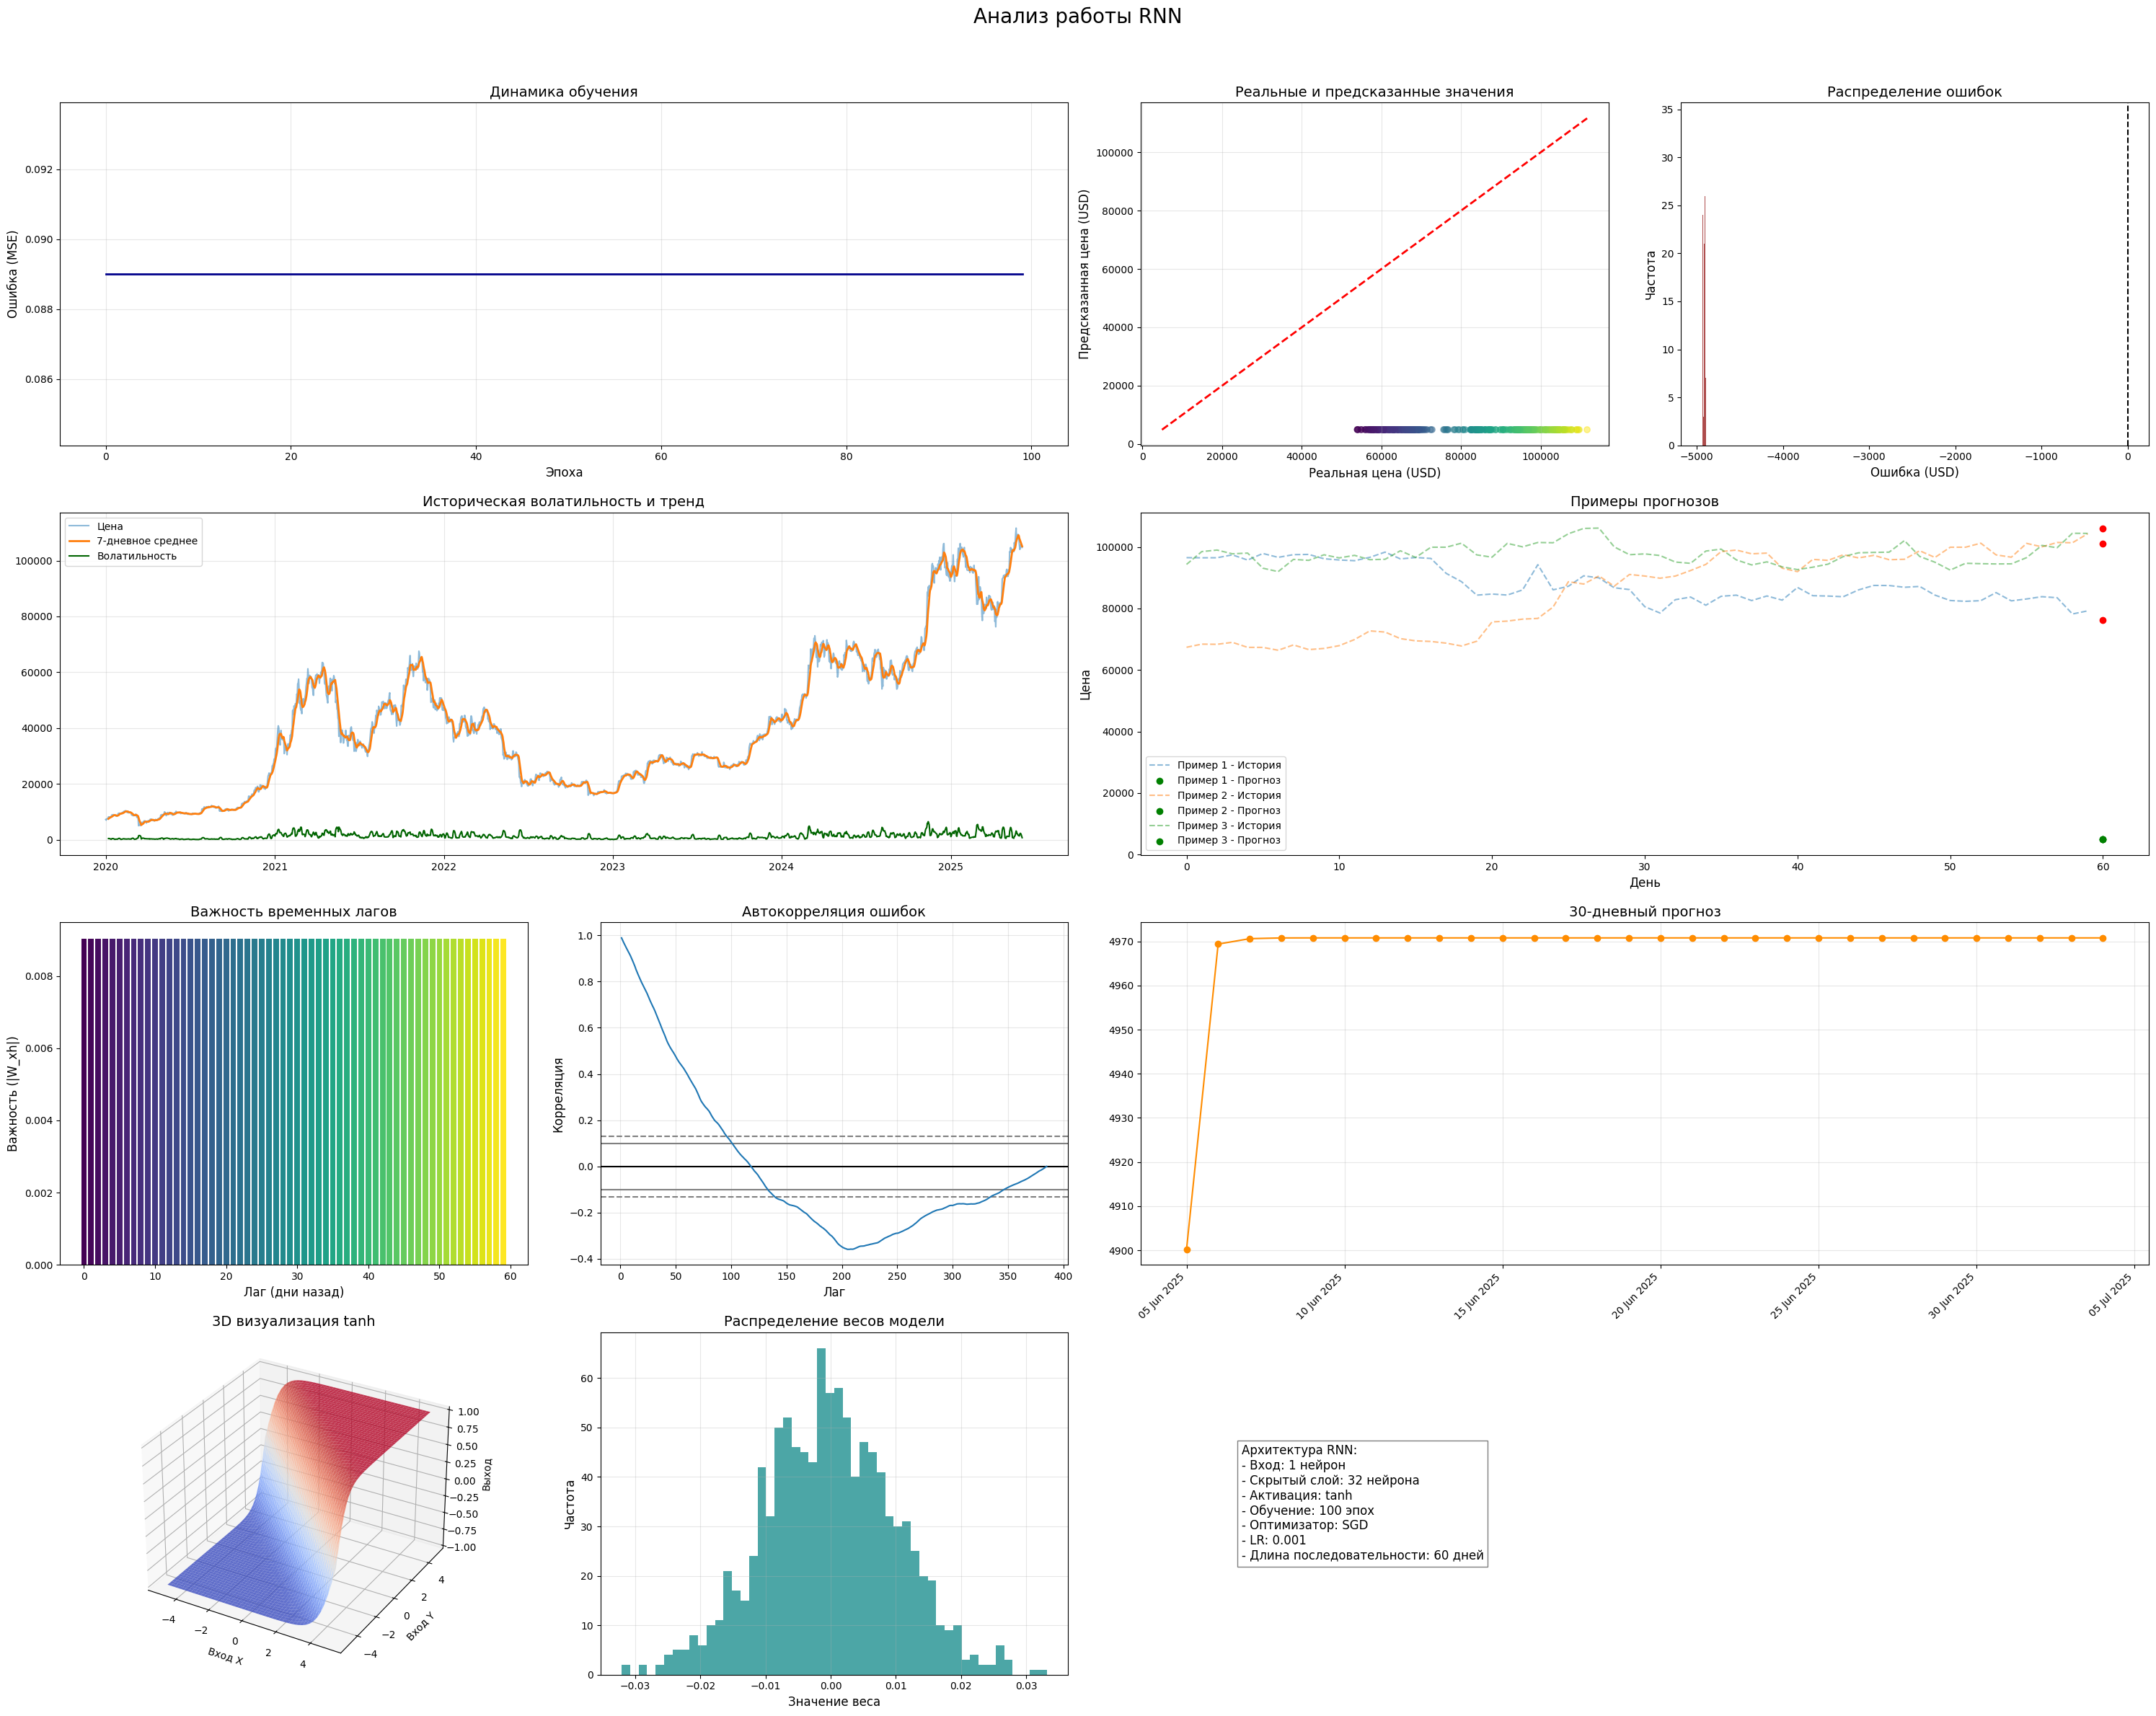

In [7]:
# Загрузка данных
ticker = "BTC-USD"
data = yf.download(ticker, start = "2020-01-01", end = pd.Timestamp.now().strftime('%Y-%m-%d'))
data = data[['Close']]

# Нормализация данных
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data)

# Создание последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Разделение данных
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Реализация RNN
class SimpleRNN:
    def __init__(self, input_size, hidden_size):
        self.W_xh = np.random.randn(hidden_size, input_size) * 0.01
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.b_h = np.zeros((hidden_size, 1))
        self.W_hy = np.random.randn(1, hidden_size) * 0.01
        self.b_y = np.zeros((1, 1))
    
    def forward(self, inputs):
        h_prev = np.zeros((self.W_hh.shape[0], 1))
        self.hs = [h_prev]
        self.outputs = []
        for x in inputs:
            x = x.reshape(-1, 1)
            h = np.tanh(self.W_xh @ x + self.W_hh @ h_prev + self.b_h)
            y = self.W_hy @ h + self.b_y
            self.hs.append(h)
            self.outputs.append(y)
            h_prev = h
        return self.outputs[-1]
    
    def backward(self, inputs, target, lr=0.001, truncate_steps = 10): # Изменение 1: Добавлен параметр
        dW_xh, dW_hh, db_h = 0, 0, 0
        dW_hy, db_y = 0, 0
        dh_next = np.zeros_like(self.hs[0])
        
        dy = (self.outputs[-1] - target.reshape(-1, 1))
        dW_hy += dy @ self.hs[-1].T
        db_y += dy
        
        dh = self.W_hy.T @ dy + dh_next
        
        # Изменение 2: Ограничение диапазона шагов для BPTT
        start_step = max(0, len(inputs) - truncate_steps)
        for t in reversed(range(start_step, len(inputs))): # Только последние truncate_steps шагов
            x = inputs[t].reshape(-1, 1)
            h_current = self.hs[t+1]
            h_prev = self.hs[t]
            
            dtanh = (1 - h_current ** 2) * dh
            dW_xh += dtanh @ x.T
            dW_hh += dtanh @ h_prev.T
            db_h += dtanh
            
            dh = self.W_hh.T @ dtanh

# Параметры модели
input_size = 1
hidden_size = 32
lr = 0.001
epochs = 100

rnn = SimpleRNN(input_size, hidden_size)

# Обучение модели
loss_history = []
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(len(X_train)):
        inputs = X_train[i].reshape(-1, 1)
        target = y_train[i]
        
        output = rnn.forward(inputs)
        loss = (output - target.reshape(-1, 1)) ** 2
        epoch_loss += loss.item()
        
        # Изменение 3: Передаем truncate_steps в backward
        rnn.backward(inputs, target, lr, truncate_steps = 10) # Усечение на 10 шагов
    
    avg_loss = epoch_loss / len(X_train)
    loss_history.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

# Функция прогнозирования
def forecast(model, last_sequence, days = 30):
    predictions = []
    current_seq = last_sequence.copy()
    for _ in range(days):
        next_pred = model.forward(current_seq)
        predictions.append(next_pred.item())
        current_seq = np.append(current_seq[1:], next_pred)
    return predictions

# Генерация предсказаний на тестовых данных
test_predictions = []
for i in range(len(X_test)):
    inputs = X_test[i].reshape(-1, 1)
    output = rnn.forward(inputs)
    test_predictions.append(output.item())

# Преобразование предсказаний обратно в исходный масштаб цен
test_predictions_inv = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Прогноз на N дней
last_sequence = scaled_data[-seq_length:].reshape(-1, 1)
scaled_forecast = forecast(rnn, last_sequence, days = 30)
forecast_prices = scaler.inverse_transform(np.array(scaled_forecast).reshape(-1, 1))

# Создание единой фигуры с subplots
plt.figure(figsize = (30, 25))
plt.suptitle("Анализ работы RNN", y = 0.95, fontsize = 20)

# 1. График обучения
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan = 2)
ax1.plot(loss_history, color = "darkblue", linewidth = 2)
ax1.set_title("Динамика обучения", fontsize = 14)
ax1.set_xlabel("Эпоха", fontsize = 12)
ax1.set_ylabel("Ошибка (MSE)", fontsize = 12)
ax1.grid(True, alpha=0.3)

# 2. Сравнение реальных и предсказанных значений
ax2 = plt.subplot2grid((4, 4), (0, 2))
ax2.scatter(y_test_inv, test_predictions_inv, alpha = 0.5, c = np.abs(y_test_inv - test_predictions_inv), cmap = "viridis")

min_val = min(y_test_inv.min(), test_predictions_inv.min())
max_val = max(y_test_inv.max(), test_predictions_inv.max())
ax2.plot([min_val, max_val], [min_val, max_val], "--r", linewidth = 2)

ax2.set_title("Реальные и предсказанные значения", fontsize = 14)
ax2.set_xlabel("Реальная цена (USD)", fontsize = 12)
ax2.set_ylabel("Предсказанная цена (USD)", fontsize = 12)
ax2.grid(alpha = 0.3)

# 3. Распределение ошибок
ax3 = plt.subplot2grid((4, 4), (0, 3))
errors = y_test - test_predictions_inv
ax3.hist(errors, bins = 30, color = "darkred", alpha = 0.7)
ax3.set_title("Распределение ошибок", fontsize = 14)
ax3.set_xlabel("Ошибка (USD)", fontsize = 12)
ax3.set_ylabel("Частота", fontsize = 12)
ax3.axvline(x = 0, color = "black", linestyle = "--")

# 4. Скользящее среднее и волатильность
ax4 = plt.subplot2grid((4, 4), (1, 0), colspan = 2)
window_size = 7
data["MA_7"] = data["Close"].rolling(window = window_size).mean()
data["Volatility"] = data["Close"].rolling(window = window_size).std()
ax4.plot(data["Close"], label = "Цена", alpha = 0.5)
ax4.plot(data["MA_7"], label = "7-дневное среднее", linewidth = 2)
ax4.plot(data["Volatility"], label = "Волатильность", color = "darkgreen")
ax4.set_title("Историческая волатильность и тренд", fontsize = 14)
ax4.legend()
ax4.grid(alpha = 0.3)

# 5. Примеры прогнозов
ax5 = plt.subplot2grid((4, 4), (1, 2), colspan = 2)
for i in range(3):
    idx = np.random.randint(len(X_test))
    seq = X_test[idx]
    pred = rnn.forward(seq.reshape(-1, 1))
    real = scaler.inverse_transform(y_test[idx].reshape(-1, 1))
    ax5.plot(scaler.inverse_transform(seq), alpha = 0.5, linestyle = "--", label = f"Пример {i+1} - История")
    ax5.scatter(len(seq), real, color = "red", zorder = 5)
    ax5.scatter(len(seq), scaler.inverse_transform(pred), color = "green", zorder = 5, label = f"Пример {i+1} - Прогноз")
ax5.set_title("Примеры прогнозов", fontsize = 14)
ax5.set_xlabel("День", fontsize = 12)
ax5.set_ylabel("Цена", fontsize = 12)
ax5.legend()

# 6. Важность временных лагов
ax6 = plt.subplot2grid((4, 4), (2, 0))
lag_importance = np.mean(np.abs(rnn.W_xh), axis = 0)
ax6.bar(range(seq_length), lag_importance, color = plt.cm.viridis(np.linspace(0,1,seq_length)))
ax6.set_title("Важность временных лагов", fontsize = 14)
ax6.set_xlabel("Лаг (дни назад)", fontsize = 12)
ax6.set_ylabel("Важность (|W_xh|)", fontsize = 12)

# 7. Автокорреляция ошибок
ax7 = plt.subplot2grid((4, 4), (2, 1))
pd.plotting.autocorrelation_plot(errors.flatten(), ax = ax7)
ax7.set_title("Автокорреляция ошибок", fontsize = 14)
ax7.set_xlabel("Лаг", fontsize = 12)
ax7.set_ylabel("Корреляция", fontsize = 12)
ax7.grid(alpha = 0.3)

# 8. Долгосрочный прогноз
ax8 = plt.subplot2grid((4, 4), (2, 2), colspan = 2)
forecast_dates = pd.date_range(start = data.index[-1], periods = 31)[1:]
ax8.plot(forecast_dates, forecast_prices, marker = "o", markersize = 6, linestyle = "-", color = "darkorange")
ax8.set_title("30-дневный прогноз", fontsize = 14)
ax8.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
ax8.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
plt.setp(ax8.get_xticklabels(), rotation = 45, ha = "right")
ax8.grid(True, alpha = 0.3)

# 9. 3D визуализация функции активации
ax9 = plt.subplot2grid((4, 4), (3, 0), projection = "3d")
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.tanh(X + Y)
ax9.plot_surface(X, Y, Z, cmap = "coolwarm", alpha = 0.8)
ax9.set_title("3D визуализация tanh", fontsize = 14)
ax9.set_xlabel("Вход X")
ax9.set_ylabel("Вход Y")
ax9.set_zlabel("Выход")

# 10. Распределение весов
ax10 = plt.subplot2grid((4, 4), (3, 1))
gradients = np.concatenate([rnn.W_xh.flatten(), rnn.W_hh.flatten()])
ax10.hist(gradients, bins = 50, color = "teal", alpha = 0.7)
ax10.set_title("Распределение весов модели", fontsize = 14)
ax10.set_xlabel("Значение веса", fontsize = 12)
ax10.set_ylabel("Частота", fontsize = 12)
ax10.grid(True, alpha = 0.3)

# 11. Легенда модели
ax11 = plt.subplot2grid((4, 4), (3, 2), colspan = 2)
ax11.axis("off")
text = """Архитектура RNN:
- Вход: 1 нейрон
- Скрытый слой: 32 нейрона
- Активация: tanh
- Обучение: 100 эпох
- Оптимизатор: SGD
- LR: 0.001
- Длина последовательности: 60 дней"""
ax11.text(0.1, 0.5, text, fontsize = 12, va = "center", bbox = dict(facecolor = "white", alpha = 0.5))

plt.tight_layout(rect = [0, 0, 1, 0.93])
plt.show()

### Нормализация градиентов

[*********************100%***********************]  1 of 1 completed


Epoch 0, Loss: 0.040389


Epoch 10, Loss: 0.023420
Epoch 20, Loss: 0.023154
Epoch 30, Loss: 0.022639
Epoch 40, Loss: 0.021613
Epoch 50, Loss: 0.019598
Epoch 60, Loss: 0.015864
Epoch 70, Loss: 0.009881
Epoch 80, Loss: 0.003360
Epoch 90, Loss: 0.000493


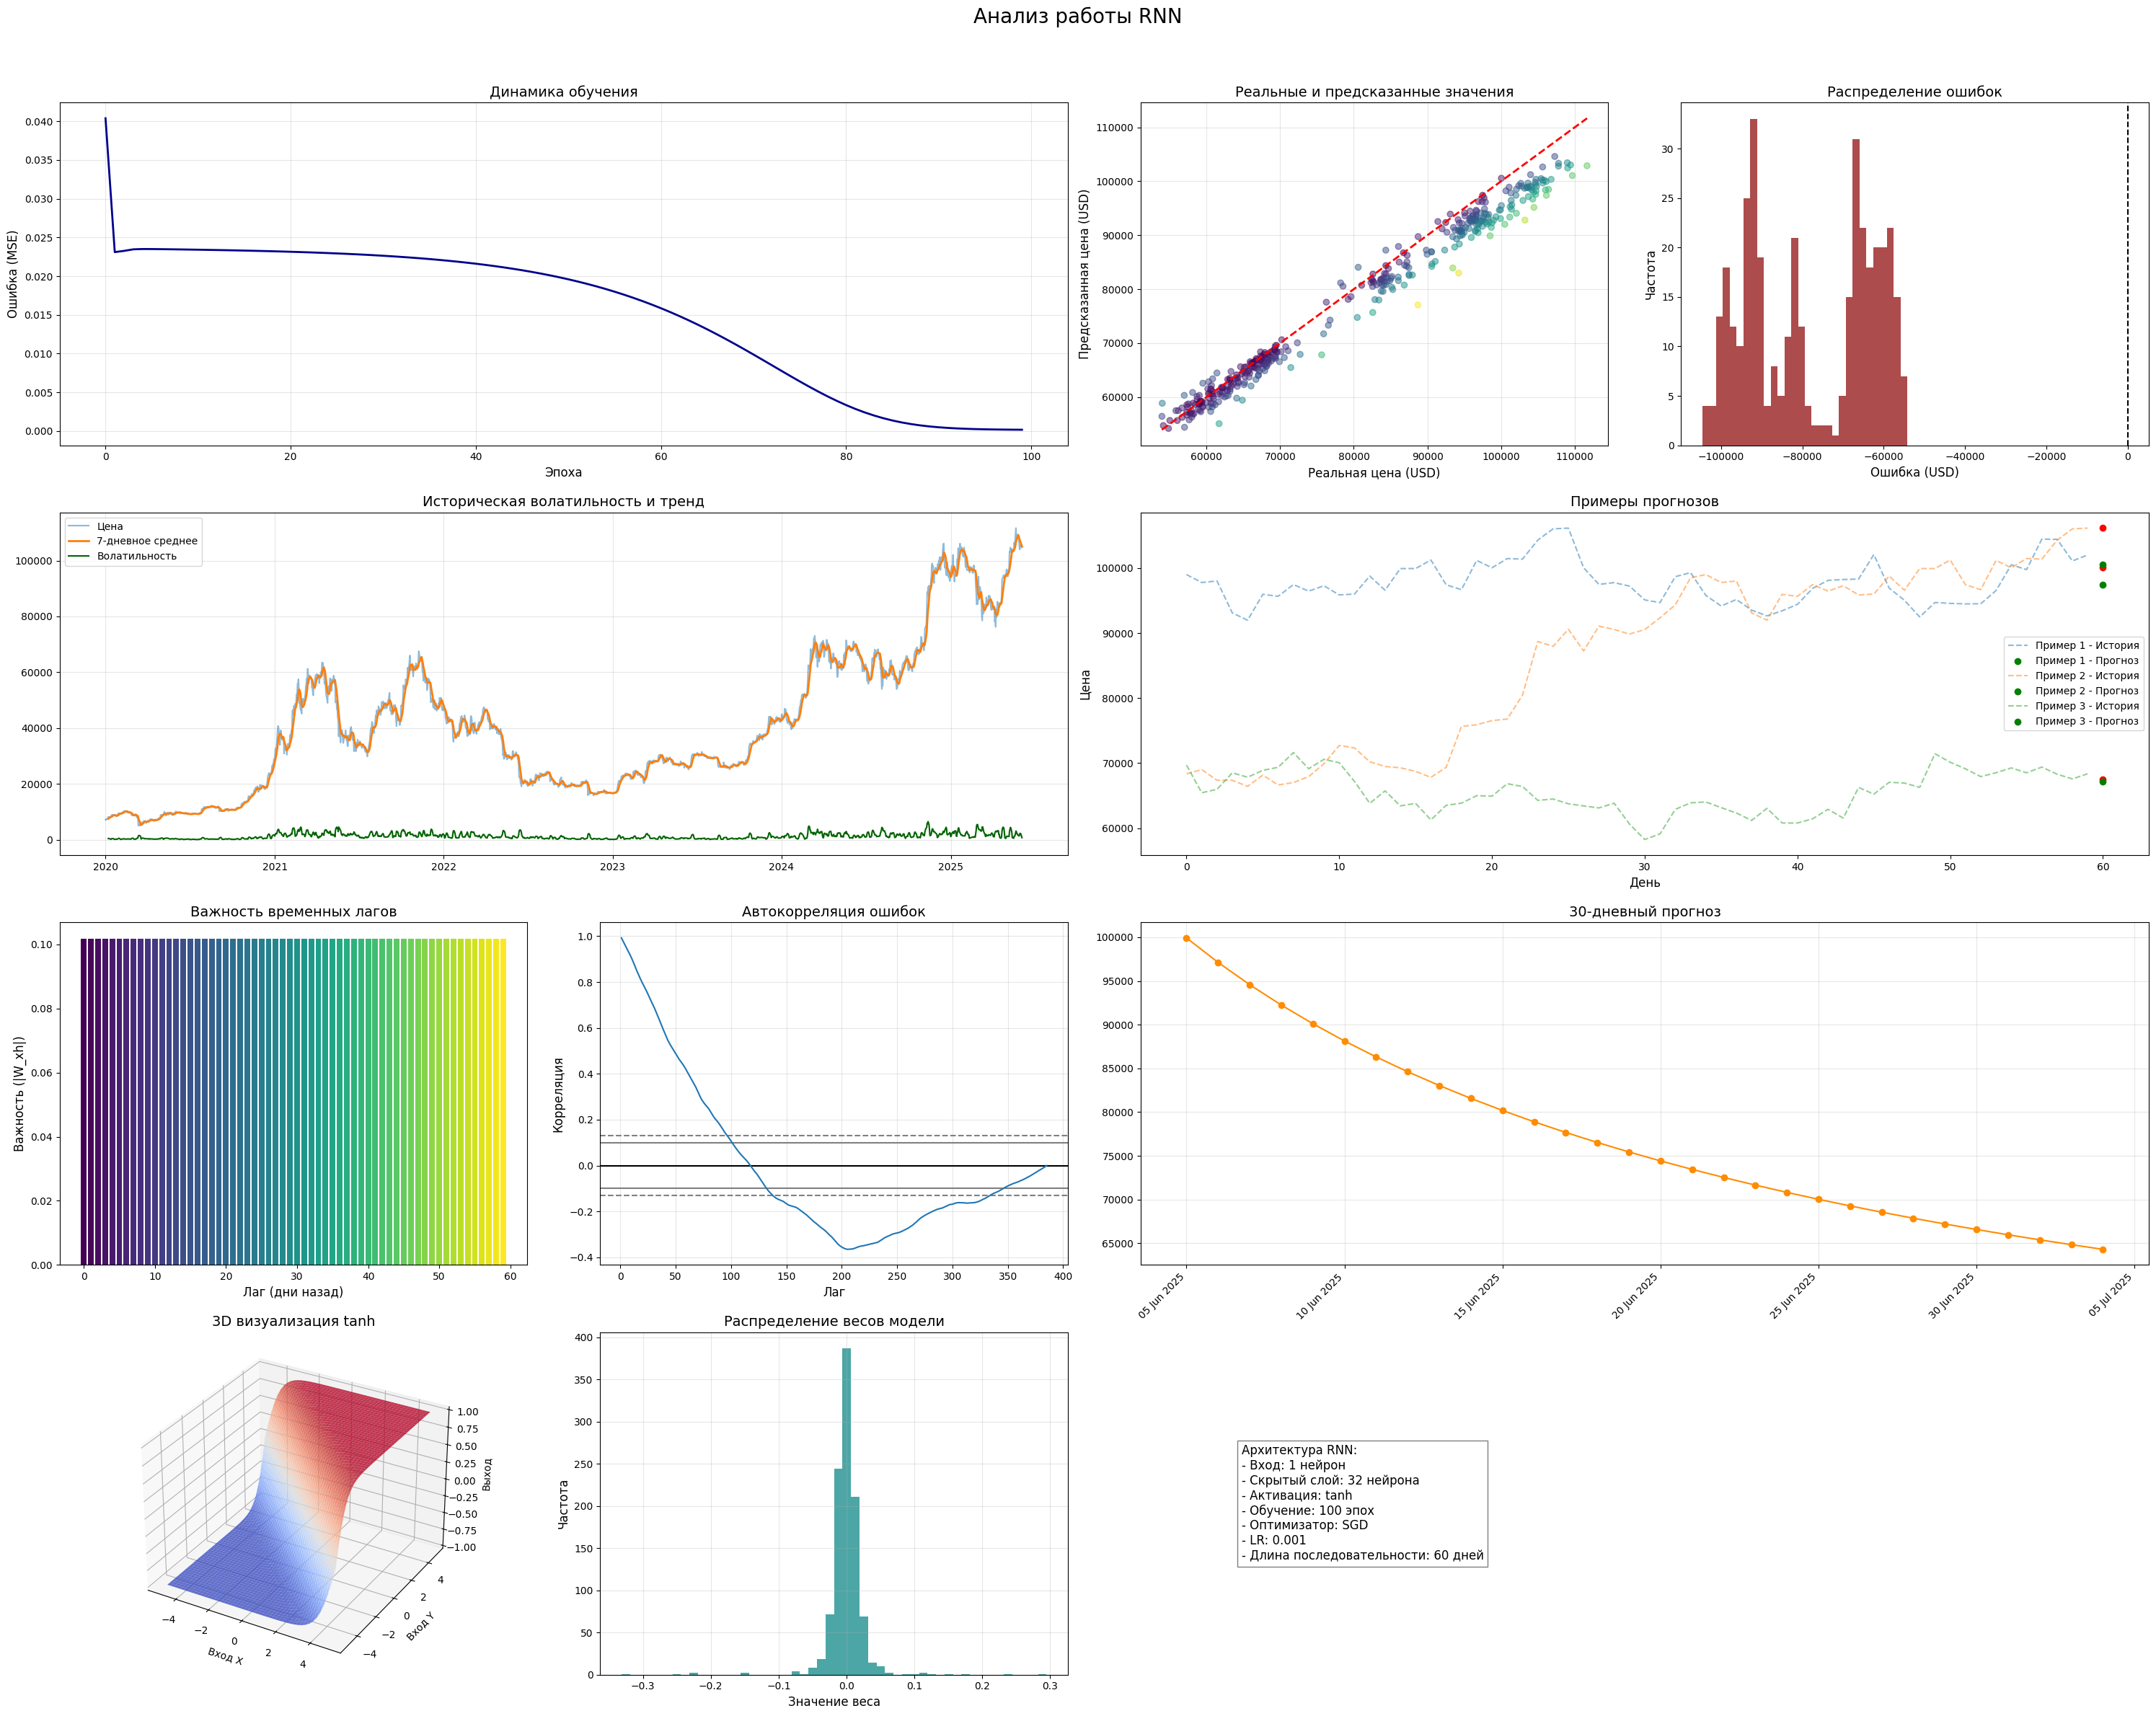

In [8]:
# Загрузка данных
ticker = "BTC-USD"
data = yf.download(ticker, start = "2020-01-01", end = pd.Timestamp.now().strftime('%Y-%m-%d'))
data = data[['Close']]

# Нормализация данных
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data)

# Создание последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Разделение данных
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Реализация RNN
class SimpleRNN:
    def __init__(self, input_size, hidden_size):
        self.W_xh = np.random.randn(hidden_size, input_size) * 0.01
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.b_h = np.zeros((hidden_size, 1))
        self.W_hy = np.random.randn(1, hidden_size) * 0.01
        self.b_y = np.zeros((1, 1))
    
    def forward(self, inputs):
        h_prev = np.zeros((self.W_hh.shape[0], 1))
        self.hs = [h_prev]
        self.outputs = []
        for x in inputs:
            x = x.reshape(-1, 1)
            h = np.tanh(self.W_xh @ x + self.W_hh @ h_prev + self.b_h)
            y = self.W_hy @ h + self.b_y
            self.hs.append(h)
            self.outputs.append(y)
            h_prev = h
        return self.outputs[-1]
    
    def backward(self, inputs, target, lr=0.001, clip_norm=5.0): # Изменение 1: clip_norm вместо truncate_steps
        dW_xh, dW_hh, db_h = 0, 0, 0
        dW_hy, db_y = 0, 0
        dh_next = np.zeros_like(self.hs[0])
        
        dy = (self.outputs[-1] - target.reshape(-1, 1))
        dW_hy += dy @ self.hs[-1].T
        db_y += dy
        
        dh = self.W_hy.T @ dy + dh_next
        
        # Изменение 2: Возвращение полного BPTT без усечения шагов
        for t in reversed(range(len(inputs))): # Обработка всех шагов
            x = inputs[t].reshape(-1, 1)
            h_current = self.hs[t+1]
            h_prev = self.hs[t]
            
            dtanh = (1 - h_current ** 2) * dh
            dW_xh += dtanh @ x.T
            dW_hh += dtanh @ h_prev.T
            db_h += dtanh
            
            dh = self.W_hh.T @ dtanh
        
        # Изменение 3: Gradient Clipping по L2-норме
        grads = [dW_xh, dW_hh, db_h, dW_hy, db_y]
        global_norm = np.sqrt(sum(np.sum(g**2) for g in grads)) # Подсчет общей нормы
        
        if global_norm > clip_norm:
            scale = clip_norm / global_norm
            for g in grads:
                g *= scale # Масштабирование всех градиентов
        
        # Обновление весов (без изменений)
        self.W_xh -= lr * dW_xh
        self.W_hh -= lr * dW_hh
        self.b_h -= lr * db_h
        self.W_hy -= lr * dW_hy
        self.b_y -= lr * db_y

# Параметры модели
input_size = 1
hidden_size = 32
lr = 0.001
epochs = 100

rnn = SimpleRNN(input_size, hidden_size)

# Обучение модели
loss_history = []
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(len(X_train)):
        inputs = X_train[i].reshape(-1, 1)
        target = y_train[i]
        
        output = rnn.forward(inputs)
        loss = (output - target.reshape(-1, 1)) ** 2
        epoch_loss += loss.item()
        
        # Изменение 4: Вызов backward без параметра truncate_steps
        rnn.backward(inputs, target, lr, clip_norm = 5.0) # clip_norm вместо truncate_steps
    
    avg_loss = epoch_loss / len(X_train)
    loss_history.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

# Функция прогнозирования
def forecast(model, last_sequence, days = 30):
    predictions = []
    current_seq = last_sequence.copy()
    for _ in range(days):
        next_pred = model.forward(current_seq)
        predictions.append(next_pred.item())
        current_seq = np.append(current_seq[1:], next_pred)
    return predictions

# Генерация предсказаний на тестовых данных
test_predictions = []
for i in range(len(X_test)):
    inputs = X_test[i].reshape(-1, 1)
    output = rnn.forward(inputs)
    test_predictions.append(output.item())

# Преобразование предсказаний обратно в исходный масштаб цен
test_predictions_inv = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Прогноз на N дней
last_sequence = scaled_data[-seq_length:].reshape(-1, 1)
scaled_forecast = forecast(rnn, last_sequence, days = 30)
forecast_prices = scaler.inverse_transform(np.array(scaled_forecast).reshape(-1, 1))

# Создание единой фигуры с subplots
plt.figure(figsize = (30, 25))
plt.suptitle("Анализ работы RNN", y = 0.95, fontsize = 20)

# 1. График обучения
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan = 2)
ax1.plot(loss_history, color = "darkblue", linewidth = 2)
ax1.set_title("Динамика обучения", fontsize = 14)
ax1.set_xlabel("Эпоха", fontsize = 12)
ax1.set_ylabel("Ошибка (MSE)", fontsize = 12)
ax1.grid(True, alpha=0.3)

# 2. Сравнение реальных и предсказанных значений
ax2 = plt.subplot2grid((4, 4), (0, 2))
ax2.scatter(y_test_inv, test_predictions_inv, alpha = 0.5, c = np.abs(y_test_inv - test_predictions_inv), cmap = "viridis")

min_val = min(y_test_inv.min(), test_predictions_inv.min())
max_val = max(y_test_inv.max(), test_predictions_inv.max())
ax2.plot([min_val, max_val], [min_val, max_val], "--r", linewidth = 2)

ax2.set_title("Реальные и предсказанные значения", fontsize = 14)
ax2.set_xlabel("Реальная цена (USD)", fontsize = 12)
ax2.set_ylabel("Предсказанная цена (USD)", fontsize = 12)
ax2.grid(alpha = 0.3)

# 3. Распределение ошибок
ax3 = plt.subplot2grid((4, 4), (0, 3))
errors = y_test - test_predictions_inv
ax3.hist(errors, bins = 30, color = "darkred", alpha = 0.7)
ax3.set_title("Распределение ошибок", fontsize = 14)
ax3.set_xlabel("Ошибка (USD)", fontsize = 12)
ax3.set_ylabel("Частота", fontsize = 12)
ax3.axvline(x = 0, color = "black", linestyle = "--")

# 4. Скользящее среднее и волатильность
ax4 = plt.subplot2grid((4, 4), (1, 0), colspan = 2)
window_size = 7
data["MA_7"] = data["Close"].rolling(window = window_size).mean()
data["Volatility"] = data["Close"].rolling(window = window_size).std()
ax4.plot(data["Close"], label = "Цена", alpha = 0.5)
ax4.plot(data["MA_7"], label = "7-дневное среднее", linewidth = 2)
ax4.plot(data["Volatility"], label = "Волатильность", color = "darkgreen")
ax4.set_title("Историческая волатильность и тренд", fontsize = 14)
ax4.legend()
ax4.grid(alpha = 0.3)

# 5. Примеры прогнозов
ax5 = plt.subplot2grid((4, 4), (1, 2), colspan = 2)
for i in range(3):
    idx = np.random.randint(len(X_test))
    seq = X_test[idx]
    pred = rnn.forward(seq.reshape(-1, 1))
    real = scaler.inverse_transform(y_test[idx].reshape(-1, 1))
    ax5.plot(scaler.inverse_transform(seq), alpha = 0.5, linestyle = "--", label = f"Пример {i+1} - История")
    ax5.scatter(len(seq), real, color = "red", zorder = 5)
    ax5.scatter(len(seq), scaler.inverse_transform(pred), color = "green", zorder = 5, label = f"Пример {i+1} - Прогноз")
ax5.set_title("Примеры прогнозов", fontsize = 14)
ax5.set_xlabel("День", fontsize = 12)
ax5.set_ylabel("Цена", fontsize = 12)
ax5.legend()

# 6. Важность временных лагов
ax6 = plt.subplot2grid((4, 4), (2, 0))
lag_importance = np.mean(np.abs(rnn.W_xh), axis = 0)
ax6.bar(range(seq_length), lag_importance, color = plt.cm.viridis(np.linspace(0,1,seq_length)))
ax6.set_title("Важность временных лагов", fontsize = 14)
ax6.set_xlabel("Лаг (дни назад)", fontsize = 12)
ax6.set_ylabel("Важность (|W_xh|)", fontsize = 12)

# 7. Автокорреляция ошибок
ax7 = plt.subplot2grid((4, 4), (2, 1))
pd.plotting.autocorrelation_plot(errors.flatten(), ax = ax7)
ax7.set_title("Автокорреляция ошибок", fontsize = 14)
ax7.set_xlabel("Лаг", fontsize = 12)
ax7.set_ylabel("Корреляция", fontsize = 12)
ax7.grid(alpha = 0.3)

# 8. Долгосрочный прогноз
ax8 = plt.subplot2grid((4, 4), (2, 2), colspan = 2)
forecast_dates = pd.date_range(start = data.index[-1], periods = 31)[1:]
ax8.plot(forecast_dates, forecast_prices, marker = "o", markersize = 6, linestyle = "-", color = "darkorange")
ax8.set_title("30-дневный прогноз", fontsize = 14)
ax8.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
ax8.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
plt.setp(ax8.get_xticklabels(), rotation = 45, ha = "right")
ax8.grid(True, alpha = 0.3)

# 9. 3D визуализация функции активации
ax9 = plt.subplot2grid((4, 4), (3, 0), projection = "3d")
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.tanh(X + Y)
ax9.plot_surface(X, Y, Z, cmap = "coolwarm", alpha = 0.8)
ax9.set_title("3D визуализация tanh", fontsize = 14)
ax9.set_xlabel("Вход X")
ax9.set_ylabel("Вход Y")
ax9.set_zlabel("Выход")

# 10. Распределение весов
ax10 = plt.subplot2grid((4, 4), (3, 1))
gradients = np.concatenate([rnn.W_xh.flatten(), rnn.W_hh.flatten()])
ax10.hist(gradients, bins = 50, color = "teal", alpha = 0.7)
ax10.set_title("Распределение весов модели", fontsize = 14)
ax10.set_xlabel("Значение веса", fontsize = 12)
ax10.set_ylabel("Частота", fontsize = 12)
ax10.grid(True, alpha = 0.3)

# 11. Легенда модели
ax11 = plt.subplot2grid((4, 4), (3, 2), colspan = 2)
ax11.axis("off")
text = """Архитектура RNN:
- Вход: 1 нейрон
- Скрытый слой: 32 нейрона
- Активация: tanh
- Обучение: 100 эпох
- Оптимизатор: SGD
- LR: 0.001
- Длина последовательности: 60 дней"""
ax11.text(0.1, 0.5, text, fontsize = 12, va = "center", bbox = dict(facecolor = "white", alpha = 0.5))

plt.tight_layout(rect = [0, 0, 1, 0.93])
plt.show()

## Процесс обучения LSTM

[*********************100%***********************]  1 of 1 completed


Epoch 0, Loss: 0.000875


Epoch 10, Loss: 0.005101
Epoch 20, Loss: 0.000534
Epoch 30, Loss: 0.000326
Epoch 40, Loss: 0.000281
Epoch 50, Loss: 0.000276
Epoch 60, Loss: 0.000258
Epoch 70, Loss: 0.000240
Epoch 80, Loss: 0.000237
Epoch 90, Loss: 0.000218


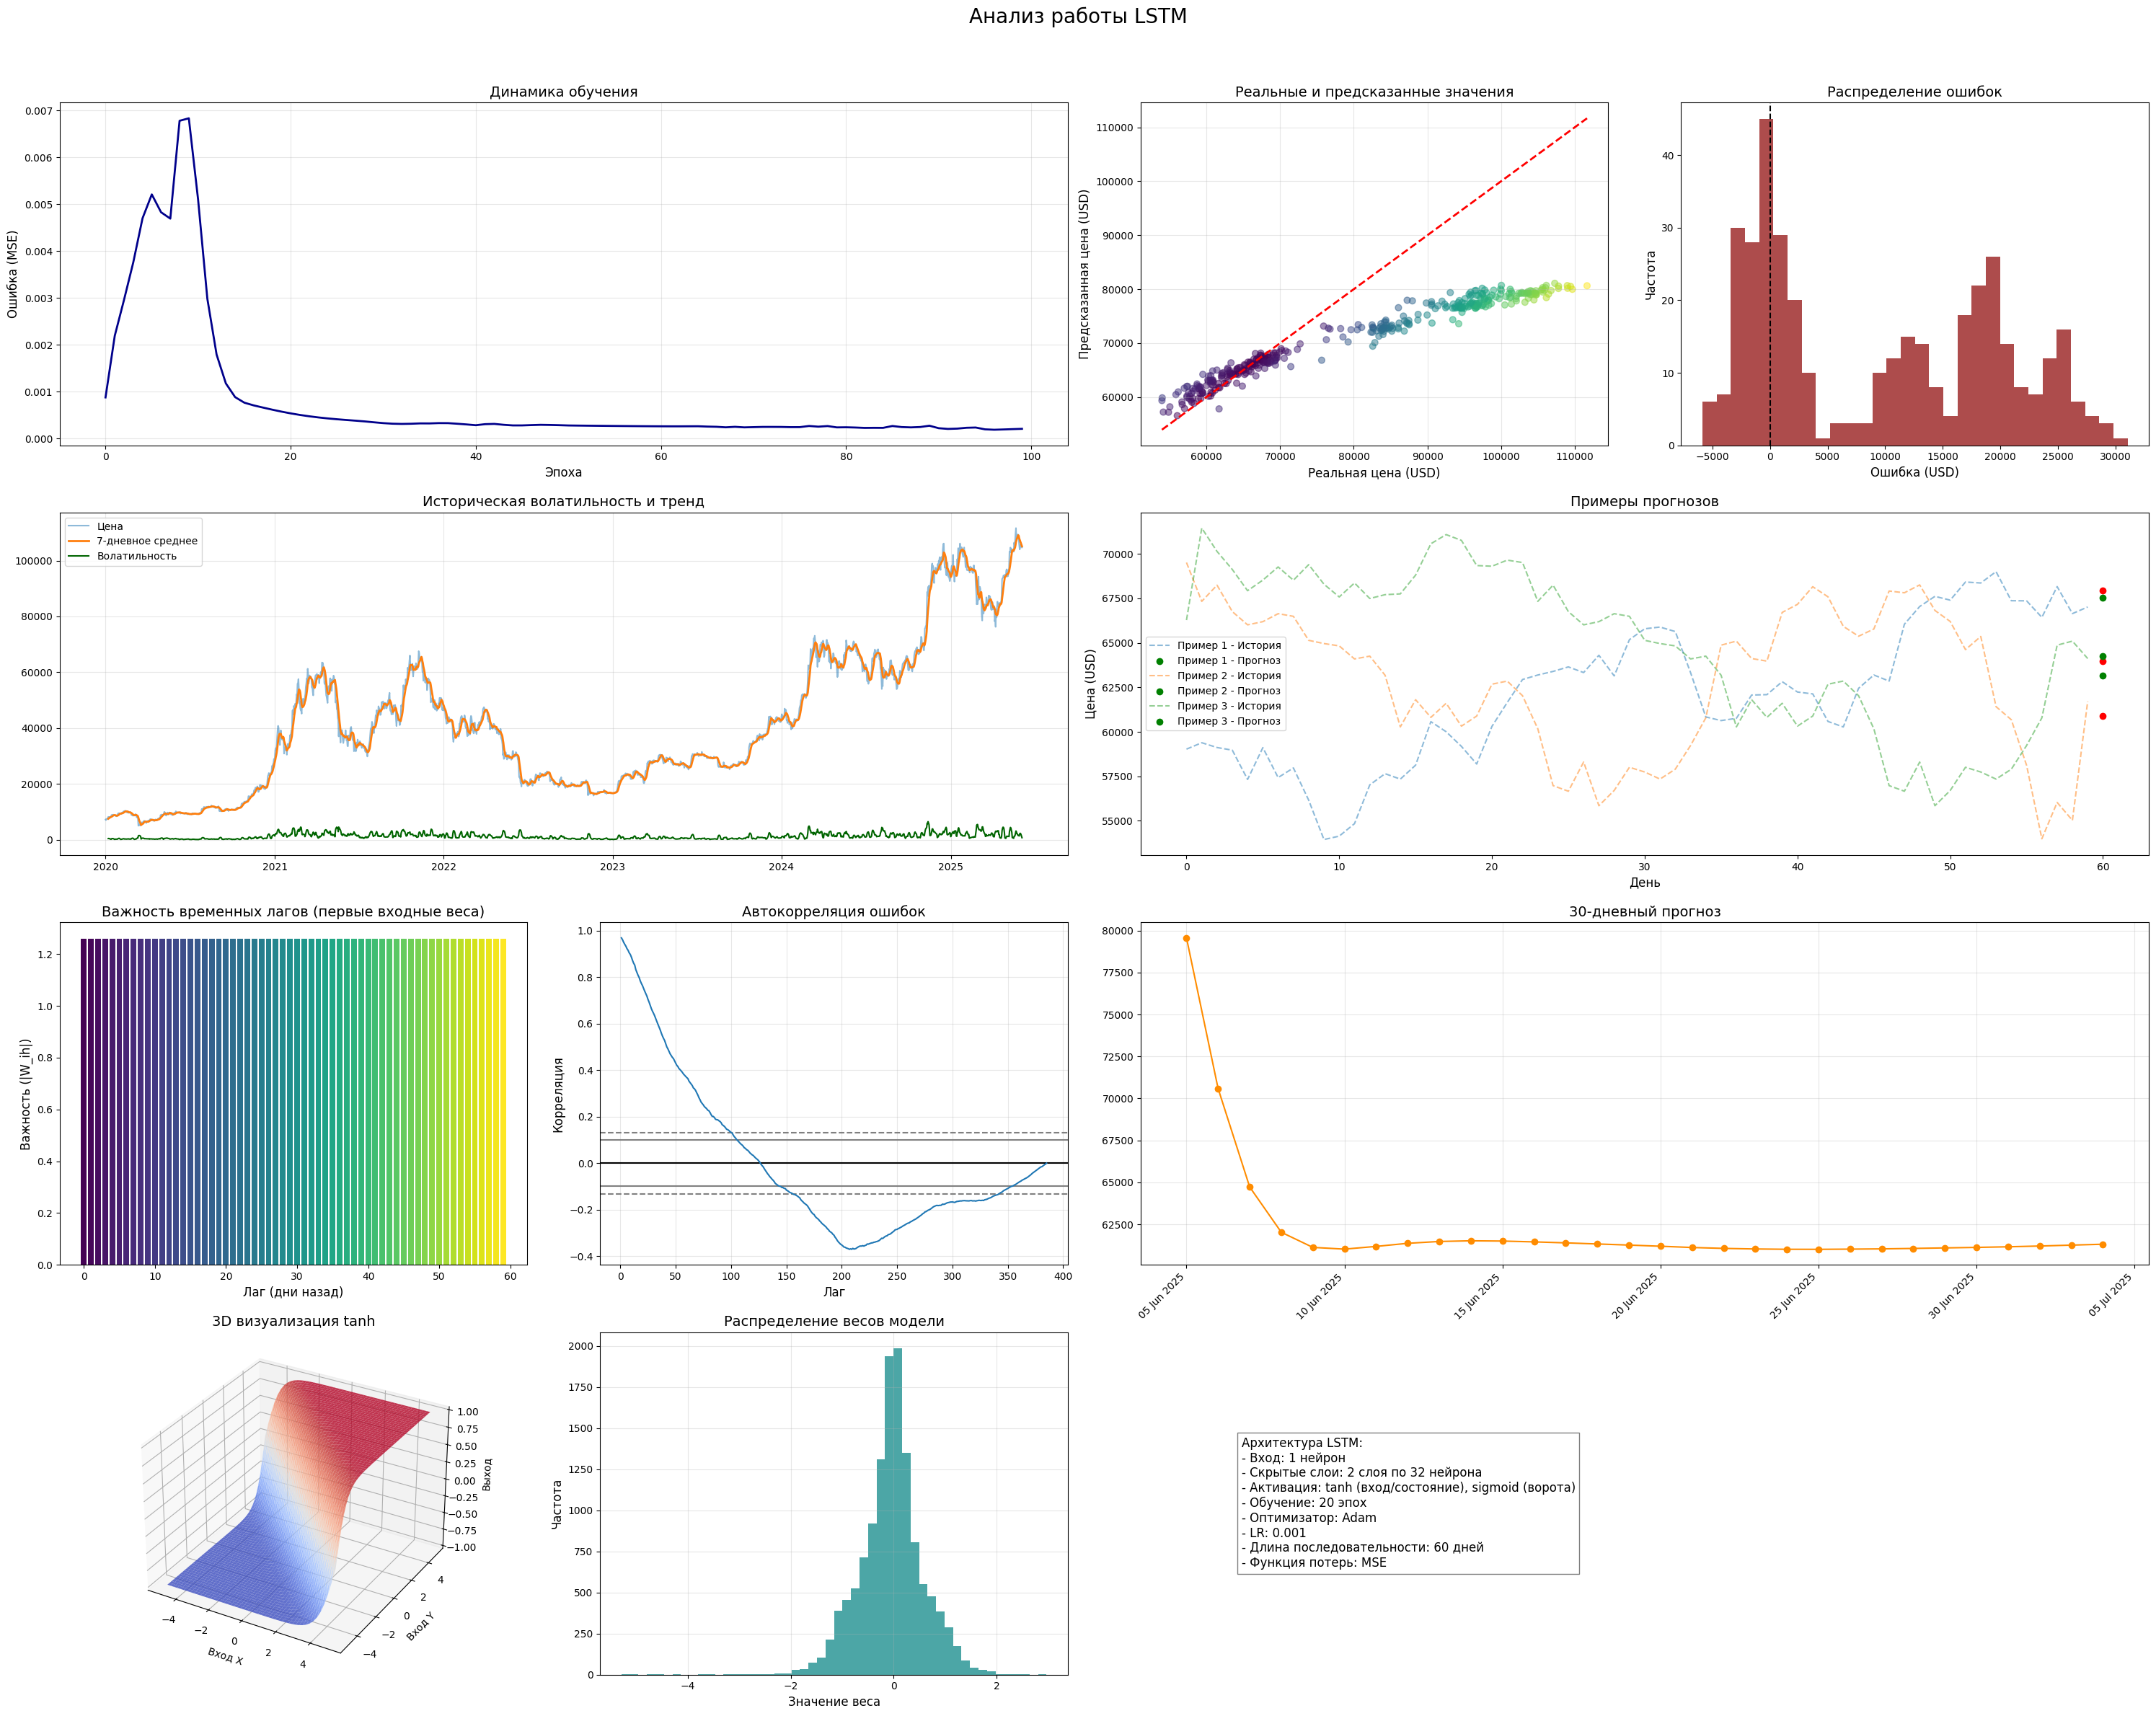

In [9]:
# Загрузка данных
ticker = "BTC-USD"
data = yf.download(ticker, start = "2020-01-01", end=pd.Timestamp.now().strftime("%Y-%m-%d"))
data = data[["Close"]]

# Нормализация данных
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data)

# Создание последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return torch.FloatTensor(X), torch.FloatTensor(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Разделение данных
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Определение LSTM модели
class BitcoinLSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 32, num_layers = 2):
        super(BitcoinLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# Инициализация модели
model = BitcoinLSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Обучение модели
num_epochs = 100
train_loss = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for i in range(len(X_train)):
        inputs = X_train[i].unsqueeze(0)
        target = y_train[i].unsqueeze(0)
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(X_train)
    train_loss.append(avg_loss)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {avg_loss:.6f}')

# Прогнозирование
def forecast(model, sequence, days = 30):
    current_seq = sequence.squeeze(0)
    predictions = []
    for _ in range(days):
        pred = model(current_seq.unsqueeze(0))
        predictions.append(pred.item())
        current_seq = torch.cat((current_seq[1:], pred))
    return predictions

# Генерация прогноза
last_sequence = scaled_data[-seq_length:]
input_tensor = torch.FloatTensor(last_sequence).unsqueeze(0)
scaled_forecast = forecast(model, input_tensor, days = 30)
forecast_prices = scaler.inverse_transform(np.array(scaled_forecast).reshape(-1, 1))

# Преобразование предсказаний и тестовых данных
model.eval()
test_predictions = []
with torch.no_grad():
    for seq in X_test:
        pred = model(seq.unsqueeze(0))
        test_predictions.append(pred.item())

test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# Создание единой фигуры с subplots
plt.figure(figsize = (30, 25))
plt.suptitle("Анализ работы LSTM", y = 0.95, fontsize = 20)

# 1. График обучения
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan = 2)
ax1.plot(train_loss, color = "darkblue", linewidth = 2)
ax1.set_title("Динамика обучения", fontsize = 14)
ax1.set_xlabel("Эпоха", fontsize = 12)
ax1.set_ylabel("Ошибка (MSE)", fontsize = 12)
ax1.grid(True, alpha = 0.3)

# 2. Сравнение реальных и предсказанных значений
ax2 = plt.subplot2grid((4, 4), (0, 2))
ax2.scatter(y_test_original, test_predictions, alpha = 0.5, c = np.abs(y_test_original - test_predictions), cmap = "viridis", s = 40)
ax2.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], "--r", linewidth = 2)
ax2.set_title("Реальные и предсказанные значения", fontsize = 14)
ax2.set_xlabel("Реальная цена (USD)", fontsize = 12)
ax2.set_ylabel("Предсказанная цена (USD)", fontsize = 12)
ax2.grid(alpha = 0.3)

# 3. Распределение ошибок
ax3 = plt.subplot2grid((4, 4), (0, 3))
errors = y_test_original - test_predictions
ax3.hist(errors, bins = 30, color = "darkred", alpha = 0.7)
ax3.set_title("Распределение ошибок", fontsize = 14)
ax3.set_xlabel("Ошибка (USD)", fontsize = 12)
ax3.set_ylabel("Частота", fontsize = 12)
ax3.axvline(x = 0, color = "black", linestyle = "--")

# 4. Скользящее среднее и волатильность
ax4 = plt.subplot2grid((4, 4), (1, 0), colspan = 2)
window_size = 7
data["MA_7"] = data["Close"].rolling(window = window_size).mean()
data["Volatility"] = data["Close"].rolling(window = window_size).std()
ax4.plot(data["Close"], label = "Цена", alpha = 0.5)
ax4.plot(data["MA_7"], label = "7-дневное среднее", linewidth = 2)
ax4.plot(data["Volatility"], label = "Волатильность", color = "darkgreen")
ax4.set_title("Историческая волатильность и тренд", fontsize = 14)
ax4.legend()
ax4.grid(alpha = 0.3)

# 5. Примеры прогнозов
ax5 = plt.subplot2grid((4, 4), (1, 2), colspan = 2)
for i in range(3):
    idx = np.random.randint(len(X_test))
    seq = X_test[idx].numpy()
    with torch.no_grad():
        pred = model(X_test[idx].unsqueeze(0))
    real = scaler.inverse_transform(y_test[idx].numpy().reshape(-1, 1))
    
    ax5.plot(scaler.inverse_transform(seq), alpha = 0.5, linestyle = "--", label = f"Пример {i+1} - История")
    ax5.scatter(len(seq), real, color = "red", zorder = 5)
    ax5.scatter(len(seq), scaler.inverse_transform(pred.numpy()), color = "green", zorder = 5, label = f"Пример {i+1} - Прогноз")
ax5.set_title("Примеры прогнозов", fontsize = 14)
ax5.set_xlabel("День", fontsize = 12)
ax5.set_ylabel("Цена (USD)", fontsize = 12)
ax5.legend()

# 6. Важность временных лагов (адаптированная для LSTM)
ax6 = plt.subplot2grid((4, 4), (2, 0))
# Получаем веса входного слоя LSTM
lstm_weights = model.lstm.weight_ih_l0.detach().numpy()
# Средние значения весов по всем нейронам
lag_importance = np.mean(np.abs(lstm_weights[:model.hidden_size]), axis = 0)
ax6.bar(range(seq_length), lag_importance[:seq_length], color = plt.cm.viridis(np.linspace(0, 1, seq_length)))
ax6.set_title("Важность временных лагов (первые входные веса)", fontsize = 14)
ax6.set_xlabel("Лаг (дни назад)", fontsize = 12)
ax6.set_ylabel("Важность (|W_ih|)", fontsize = 12)

# 7. Автокорреляция ошибок
ax7 = plt.subplot2grid((4, 4), (2, 1))
pd.plotting.autocorrelation_plot(errors.flatten(), ax = ax7)
ax7.set_title("Автокорреляция ошибок", fontsize = 14)
ax7.set_xlabel("Лаг", fontsize = 12)
ax7.set_ylabel("Корреляция", fontsize = 12)
ax7.grid(alpha = 0.3)

# 8. Долгосрочный прогноз
ax8 = plt.subplot2grid((4, 4), (2, 2), colspan = 2)
forecast_dates = pd.date_range(start = data.index[-1], periods = 31)[1:]
ax8.plot(forecast_dates, forecast_prices, marker = "o", markersize = 6, linestyle = "-", color = "darkorange")
ax8.set_title("30-дневный прогноз", fontsize = 14)
ax8.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
ax8.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
plt.setp(ax8.get_xticklabels(), rotation = 45, ha = "right")
ax8.grid(True, alpha = 0.3)

# 9. 3D визуализация функции активации
ax9 = plt.subplot2grid((4, 4), (3, 0), projection = "3d")
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.tanh(X + Y)
ax9.plot_surface(X, Y, Z, cmap = "coolwarm", alpha = 0.8)
ax9.set_title("3D визуализация tanh", fontsize = 14)
ax9.set_xlabel("Вход X")
ax9.set_ylabel("Вход Y")
ax9.set_zlabel("Выход")

# 10. Распределение весов модели
ax10 = plt.subplot2grid((4, 4), (3, 1))
all_weights = []
for param in model.parameters():
    if param.requires_grad:
        all_weights.extend(param.detach().numpy().flatten())
ax10.hist(all_weights, bins = 50, color = "teal", alpha = 0.7)
ax10.set_title("Распределение весов модели", fontsize = 14)
ax10.set_xlabel("Значение веса", fontsize = 12)
ax10.set_ylabel("Частота", fontsize = 12)
ax10.grid(True, alpha = 0.3)

# 11. Легенда модели
ax11 = plt.subplot2grid((4, 4), (3, 2), colspan = 2)
ax11.axis("off")
text = """Архитектура LSTM:
- Вход: 1 нейрон
- Скрытые слои: 2 слоя по 32 нейрона
- Активация: tanh (вход/состояние), sigmoid (ворота)
- Обучение: 20 эпох
- Оптимизатор: Adam
- LR: 0.001
- Длина последовательности: 60 дней
- Функция потерь: MSE"""
ax11.text(0.1, 0.5, text, fontsize = 12, va = "center", bbox = dict(facecolor = "white", alpha = 0.5))

plt.tight_layout(rect = [0, 0, 1, 0.93])
plt.show()

## Процесс обучения GRU

In [ ]:
# Загрузка данных
ticker = "BTC-USD"
data = yf.download(ticker, start = "2020-01-01", end=pd.Timestamp.now().strftime("%Y-%m-%d"))
data = data[["Close"]]

# Нормализация данных
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data)

# Создание последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return torch.FloatTensor(X), torch.FloatTensor(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Разделение данных
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Определение GRU модели
class BitcoinGRU(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 32, num_layers = 2):
        super(BitcoinGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, hn = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

# Инициализация модели
model = BitcoinGRU()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Обучение модели
num_epochs = 20
train_loss = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for i in range(len(X_train)):
        inputs = X_train[i].unsqueeze(0)
        target = y_train[i].unsqueeze(0)
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(X_train)
    train_loss.append(avg_loss)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {avg_loss:.6f}')

# Прогнозирование
def forecast(model, sequence, days = 30):
    current_seq = sequence.squeeze(0)
    predictions = []
    for _ in range(days):
        pred = model(current_seq.unsqueeze(0))
        predictions.append(pred.item())
        current_seq = torch.cat((current_seq[1:], pred))
    return predictions

# Генерация прогноза
last_sequence = scaled_data[-seq_length:]
input_tensor = torch.FloatTensor(last_sequence).unsqueeze(0)
scaled_forecast = forecast(model, input_tensor, days = 30)
forecast_prices = scaler.inverse_transform(np.array(scaled_forecast).reshape(-1, 1))

# Преобразование предсказаний и тестовых данных
model.eval()
test_predictions = []
with torch.no_grad():
    for seq in X_test:
        pred = model(seq.unsqueeze(0))
        test_predictions.append(pred.item())

test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# Создание единой фигуры с subplots
plt.figure(figsize = (30, 25))
plt.suptitle("Анализ работы GRU", y = 0.95, fontsize = 20)

# 1. График обучения
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan = 2)
ax1.plot(train_loss, color = "darkblue", linewidth = 2)
ax1.set_title("Динамика обучения", fontsize = 14)
ax1.set_xlabel("Эпоха", fontsize = 12)
ax1.set_ylabel("Ошибка (MSE)", fontsize = 12)
ax1.grid(True, alpha = 0.3)

# 2. Сравнение реальных и предсказанных значений
ax2 = plt.subplot2grid((4, 4), (0, 2))
ax2.scatter(y_test_original, test_predictions, alpha = 0.5, c = np.abs(y_test_original - test_predictions), cmap = "viridis", s = 40)
ax2.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], "--r", linewidth = 2)
ax2.set_title("Реальные и предсказанные значения", fontsize = 14)
ax2.set_xlabel("Реальная цена (USD)", fontsize = 12)
ax2.set_ylabel("Предсказанная цена (USD)", fontsize = 12)
ax2.grid(alpha = 0.3)

# 3. Распределение ошибок
ax3 = plt.subplot2grid((4, 4), (0, 3))
errors = y_test_original - test_predictions
ax3.hist(errors, bins = 30, color = "darkred", alpha = 0.7)
ax3.set_title("Распределение ошибок", fontsize = 14)
ax3.set_xlabel("Ошибка (USD)", fontsize = 12)
ax3.set_ylabel("Частота", fontsize = 12)
ax3.axvline(x = 0, color = "black", linestyle = "--")

# 4. Скользящее среднее и волатильность
ax4 = plt.subplot2grid((4, 4), (1, 0), colspan = 2)
window_size = 7
data["MA_7"] = data["Close"].rolling(window = window_size).mean()
data["Volatility"] = data["Close"].rolling(window = window_size).std()
ax4.plot(data["Close"], label = "Цена", alpha = 0.5)
ax4.plot(data["MA_7"], label = "7-дневное среднее", linewidth = 2)
ax4.plot(data["Volatility"], label = "Волатильность", color = "darkgreen")
ax4.set_title("Историческая волатильность и тренд", fontsize = 14)
ax4.legend()
ax4.grid(alpha = 0.3)

# 5. Примеры прогнозов
ax5 = plt.subplot2grid((4, 4), (1, 2), colspan = 2)
for i in range(3):
    idx = np.random.randint(len(X_test))
    seq = X_test[idx].numpy()
    with torch.no_grad():
        pred = model(X_test[idx].unsqueeze(0))
    real = scaler.inverse_transform(y_test[idx].numpy().reshape(-1, 1))
    
    ax5.plot(scaler.inverse_transform(seq), alpha = 0.5, linestyle = "--", label = f"Пример {i+1} - История")
    ax5.scatter(len(seq), real, color = "red", zorder = 5)
    ax5.scatter(len(seq), scaler.inverse_transform(pred.numpy()), color = "green", zorder = 5, label = f"Пример {i+1} - Прогноз")
ax5.set_title("Примеры прогнозов", fontsize = 14)
ax5.set_xlabel("День", fontsize = 12)
ax5.set_ylabel("Цена (USD)", fontsize = 12)
ax5.legend()

# 6. Важность временных лагов (адаптированная для GRU)
ax6 = plt.subplot2grid((4, 4), (2, 0))
# Получаем веса входного слоя GRU
gru_weights = model.gru.weight_ih_l0.detach().numpy()
# Средние значения весов по всем нейронам
lag_importance = np.mean(np.abs(gru_weights[:model.hidden_size]), axis = 0)
ax6.bar(range(seq_length), lag_importance[:seq_length], color = plt.cm.viridis(np.linspace(0, 1, seq_length)))
ax6.set_title("Важность временных лагов (первые входные веса)", fontsize = 14)
ax6.set_xlabel("Лаг (дни назад)", fontsize = 12)
ax6.set_ylabel("Важность (|W_ih|)", fontsize = 12)

# 7. Автокорреляция ошибок
ax7 = plt.subplot2grid((4, 4), (2, 1))
pd.plotting.autocorrelation_plot(errors.flatten(), ax = ax7)
ax7.set_title("Автокорреляция ошибок", fontsize = 14)
ax7.set_xlabel("Лаг", fontsize = 12)
ax7.set_ylabel("Корреляция", fontsize = 12)
ax7.grid(alpha = 0.3)

# 8. Долгосрочный прогноз
ax8 = plt.subplot2grid((4, 4), (2, 2), colspan = 2)
forecast_dates = pd.date_range(start = data.index[-1], periods = 31)[1:]
ax8.plot(forecast_dates, forecast_prices, marker = "o", markersize = 6, linestyle = "-", color = "darkorange")
ax8.set_title("30-дневный прогноз", fontsize = 14)
ax8.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
ax8.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
plt.setp(ax8.get_xticklabels(), rotation = 45, ha = "right")
ax8.grid(True, alpha = 0.3)

# 9. 3D визуализация функции активации
ax9 = plt.subplot2grid((4, 4), (3, 0), projection = "3d")
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.tanh(X + Y)
ax9.plot_surface(X, Y, Z, cmap = "coolwarm", alpha = 0.8)
ax9.set_title("3D визуализация tanh", fontsize = 14)
ax9.set_xlabel("Вход X")
ax9.set_ylabel("Вход Y")
ax9.set_zlabel("Выход")

# 10. Распределение весов модели
ax10 = plt.subplot2grid((4, 4), (3, 1))
all_weights = []
for param in model.parameters():
    if param.requires_grad:
        all_weights.extend(param.detach().numpy().flatten())
ax10.hist(all_weights, bins = 50, color = "teal", alpha = 0.7)
ax10.set_title("Распределение весов модели", fontsize = 14)
ax10.set_xlabel("Значение веса", fontsize = 12)
ax10.set_ylabel("Частота", fontsize = 12)
ax10.grid(True, alpha = 0.3)

# 11. Легенда модели
ax11 = plt.subplot2grid((4, 4), (3, 2), colspan = 2)
ax11.axis("off")
text = """Архитектура GRU:
- Вход: 1 нейрон
- Скрытые слои: 2 слоя по 32 нейрона
- Активация: tanh (кандидатское состояние), sigmoid (ворота)
- Ворота: update (z_t), reset (r_t)
- Обучение: 20 эпох
- Оптимизатор: Adam
- LR: 0.001
- Длина последовательности: 60 дней
- Функция потерь: MSE"""
ax11.text(0.1, 0.5, text, fontsize = 12, va = "center", bbox = dict(facecolor = "white", alpha = 0.5))

plt.tight_layout(rect = [0, 0, 1, 0.93])
plt.show()

[*********************100%***********************]  1 of 1 completed


Epoch 0, Loss: 0.000831
Epoch 10, Loss: 0.000265
